# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 3</span>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy
from scipy.special import erf
from numpy.lib.scimath import log, sqrt

colors = sns.color_palette("hls", 8)   # Colors
title_size = 16                        # Size title
axis_size = 14                         # Size axis label
value_size = 10                        # Size values on axis
legend_size = 12                       # Size legend

## Exercise 03.1 
### Assignment
#### Plain vanilla option pricing 

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

Black-Scholes <span style="color:blue"> analytic solution </span> for the price at time t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

1. By sampling **directly** the final asset price $S(T)$</span> for a $GBM(r,\sigma^2)$
2. By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price</span> 
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

Make four pictures for the estimation of the European call-option prices, $C[S(0),0]$ (direct and discretized), and put-option prices, $P[S(0),0]$ (direct and discretized), with their uncertainties </span> with a large number of asset prices at time $t=T$, say $M\ge 10^4$, as a function of the number of blocks, $N$. As usual, in computing statistical uncertainties, use data blocking.

### Resolution

**European options**

In European options, the writer (seller of the option) grants the holder (buyer of the option) the right to buy (call option) or sell (put option) an asset at a fixed price (strike price $K$) on a fixed date (expiry date $T$). The holder of the option can choose to exercise the option or not, and in particular, he will exercise the option only if the operation returns a profit. His profit will be $ \max \left[0, S(T) - K \right] $ for a call and $ \max \left[0, K - S(T) \right] $ for a put, where $S(T)$ is the price of the asset.

To obtain the current value of the profit, we need to add the factor $e^{-rT}$ due to the interest rate $r$ that a bank would have guaranteed:

$$C\left[S(0),0\right]=e^{-rT}max \left[0, S(T)-K\right]$$
$$P\left[S(0),0\right]=e^{-rT}max \left[0, K-S(T)\right]$$

**Financial market**

According to Black-Scholes-Merton theory, financial time series are unpredictable due to their complexity, and considering the entire price evolution is not advantageous because an efficient market responds immediately to increased demand by increasing the price, thereby eliminating long-term correlations. Thus, the price of an asset can be modeled as a Markov process known as geometric Brownian motion $S \sim GBM(\mu, \sigma^2)$:

$$dS(t) = \mu S(t)dt + \sigma S(t)dW(t)$$

where $\mu$ is the drift (deterministic part), which measures the average growth rate of the asset price, and $\sigma$ is the volatility, which measures the strength of the statistical price fluctuations (stochastic part). With this model, the asset price follows the equation:

$$S(t) = S(0)exp{\left[\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W(t)\right]}$$

with $W$ indipedent and normaly distributed. 

Using the `S_direct` function, I directly sampled the final asset price:

```cpp
double S_direct(double& S_0, double& mu, double& sigma, double& t, Random& rn) 
{
	return S_0 * exp((mu - 0.5 * pow(sigma, 2)) * t + sigma * rn.Gauss(0, t));
}
```

Is possible sample $S \sim GBM(\mu, \sigma^2)$ using a recursive formula:

$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)+\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$

where $Z_i \in (0,1)$ normally distributed. 

Using the function `S_discretized` I discretely sampled the final asset price:

```cpp
double S_discretized(double& S_0, double& mu, double& sigma, double& t, int n, Random& rn) 
{
	double S = S_0;
	
	for (int i = 0; i < n; i++) // Loop on the interations
		S = S * exp((mu - 0.5 * pow(sigma, 2)) * t / n + sigma * rn.Gauss(0, 1) * sqrt(t / n)) ;

	return S;
}
```

I used data blocking with $M=10^7$ repetitions divided in $N=100$ blocks.

The results are consistent with the expected ones. The discretized sampling, especially for the call option, is more accurate and precise than the direct sampling.

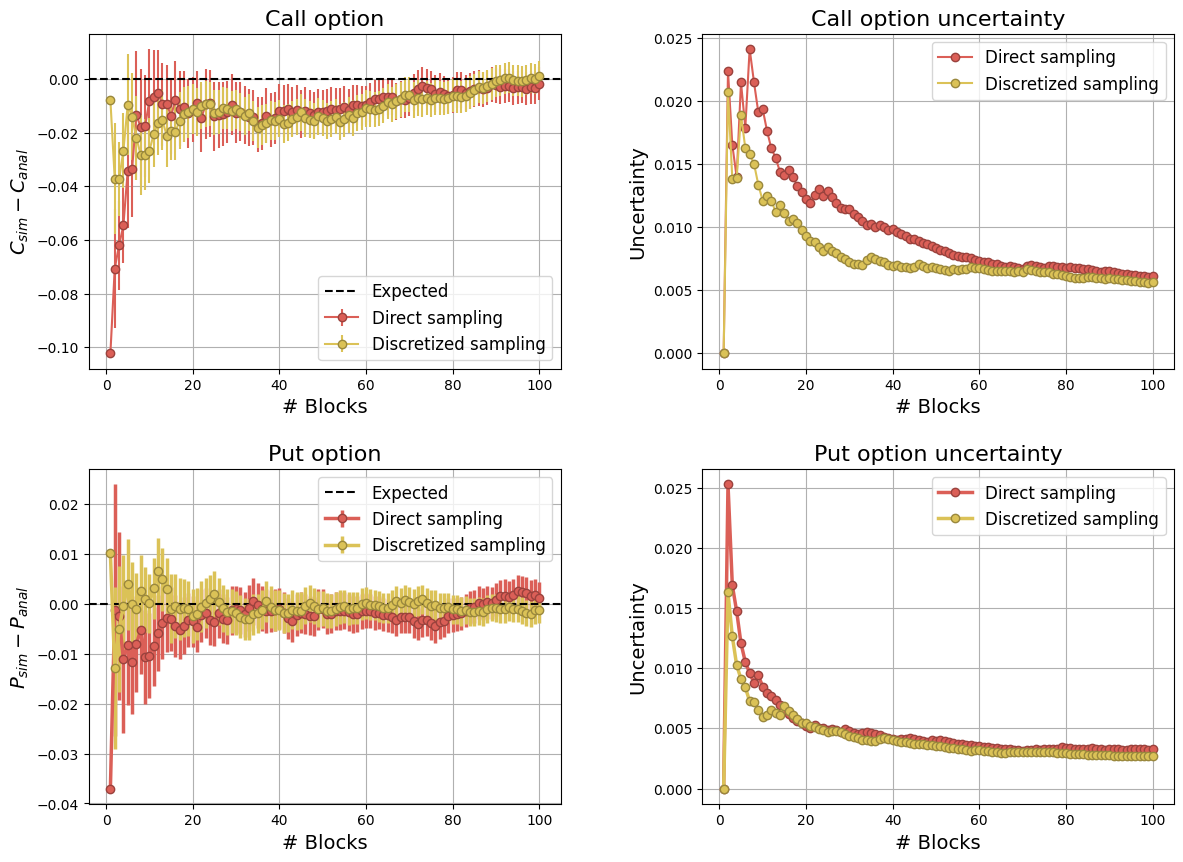

In [2]:
# Analytic solution
def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * T) * (N(d2)-1.)
    return C, P

S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0
call, put = black_scholes(S0, K, T, r, sigma)

# Data import call
df_C = pd.read_csv('../E03/data_C.dat', delimiter=' ') 

plt.figure(figsize=(14, 10))

# Plot call
plt.subplot(2, 2, 1)
plt.errorbar(df_C['block'], df_C['mean_dir'] - call, yerr = df_C['devstd_dir'], color = colors[0], linewidth=1.5, marker="o", mec=tuple(np.array(colors[0]) * 0.7), label="Direct sampling")
plt.errorbar(df_C['block'], df_C['mean_dis'] - call, yerr = df_C['devstd_dis'], color = colors[1], linewidth=1.5, marker="o", mec=tuple(np.array(colors[1]) * 0.7), label="Discretized sampling")
plt.axhline(0, color='black', linestyle='--', label="Expected")      # Line at y = 0
plt.title(r"Call option", fontsize=title_size)
plt.xlabel(r'# Blocks', fontsize=axis_size)
plt.ylabel(r'$C_{sim} - C_{anal}$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=legend_size)
plt.grid(True)

# Plot call
plt.subplot(2, 2, 2)
plt.plot(df_C['block'], df_C['devstd_dir'], color = colors[0], linewidth=1.5, marker="o", mec=tuple(np.array(colors[0]) * 0.7), label="Direct sampling")
plt.plot(df_C['block'], df_C['devstd_dis'], color = colors[1], linewidth=1.5, marker="o", mec=tuple(np.array(colors[1]) * 0.7), label="Discretized sampling")
plt.title(r"Call option uncertainty", fontsize=title_size)
plt.xlabel(r'# Blocks', fontsize=axis_size)
plt.ylabel('Uncertainty', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=legend_size)
plt.grid(True)

# Data import put
df_P = pd.read_csv('../E03/data_P.dat', delimiter=' ') 

# Plot put
plt.subplot(2, 2, 3)
plt.errorbar(df_P['block'], df_P['mean_dir'] - put, yerr = df_P['devstd_dir'], color = colors[0], linewidth=2.5, marker="o", mec=tuple(np.array(colors[0]) * 0.7), label="Direct sampling")
plt.errorbar(df_P['block'], df_P['mean_dis'] - put, yerr = df_P['devstd_dis'], color = colors[1], linewidth=2.5, marker="o", mec=tuple(np.array(colors[1]) * 0.7), label="Discretized sampling")
plt.axhline(0, color='black', linestyle='--', label="Expected")      # Line at y = 0
plt.title("Put option", fontsize=title_size)
plt.xlabel('# Blocks', fontsize=axis_size)
plt.ylabel(r'$P_{sim} - P_{anal}$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=legend_size)
plt.grid(True)

# Plot put
plt.subplot(2, 2, 4)
plt.plot(df_P['block'], df_P['devstd_dir'], color = colors[0], linewidth=2.5, marker="o", mec=tuple(np.array(colors[0]) * 0.7), label="Direct sampling")
plt.plot(df_P['block'], df_P['devstd_dis'], color = colors[1], linewidth=2.5, marker="o", mec=tuple(np.array(colors[1]) * 0.7), label="Discretized sampling")
plt.title(r"Put option uncertainty", fontsize=title_size)
plt.xlabel('# Blocks', fontsize=axis_size)
plt.ylabel('Uncertainty', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=legend_size)
plt.grid(True)

# Show plots
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()
